In [ ]:
#import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras.regularizers import l2
from keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
#!pip install scikit-learn --upgrade
from keras import Model
from sklearn.decomposition import PCA
from scipy import signal
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
import joblib
from sklearn.model_selection import GridSearchCV


In [ ]:
#import data
df1 = pd.read_csv('/content/drive/MyDrive/MPUTOYDATA/dati_andrea.csv')
df2 = pd.read_csv('/content/drive/MyDrive/MPUTOYDATA/dati_christian.csv')
df3 = pd.read_csv('/content/drive/MyDrive/MPUTOYDATA/dati_giovanni.csv')
df4 = pd.read_csv('/content/drive/MyDrive/MPUTOYDATA/dati_beste.csv')
df5 = pd.read_csv('/content/drive/MyDrive/MPUTOYDATA/dati_valerio.csv')
df6 = pd.read_csv('/content/drive/MyDrive/MPUTOYDATA/dati_giampiero.csv')
df7 = pd.read_csv('/content/drive/MyDrive/MPUTOYDATA/dati_giampiero_2.csv')
df8 = pd.read_csv('/content/drive/MyDrive/MPUTOYDATA/dati_giampiero_3.csv')
df9 = pd.read_csv('/content/drive/MyDrive/MPUTOYDATA/dati_giampiero_4.csv')
df10 = pd.read_csv('/content/drive/MyDrive/MPUTOYDATA/dati_giampiero_5.csv')
df11 = pd.read_csv('/content/drive/MyDrive/MPUTOYDATA/dati_giampiero_6.csv')
df12 = pd.read_csv('/content/drive/MyDrive/MPUTOYDATA/dati_giampiero_7.csv')
df13 = pd.read_csv('/content/drive/MyDrive/MPUTOYDATA/dati_giampiero_8.csv')
df14 = pd.read_csv('/content/drive/MyDrive/MPUTOYDATA/dati_giampiero_9.csv')
df15 = pd.read_csv('/content/drive/MyDrive/MPUTOYDATA/dati_giampiero_10.csv')
#removing all the data before the start of the protocol - run only one time!!
df1 = df1[df1.iloc[:, 9] != 'Null']
df2 = df2[df2.iloc[:, 9] != 'Null']
df3 = df3[df3.iloc[:, 9] != 'Null']
df4 = df4[df4.iloc[:, 9] != 'Null']
df5 = df5[df5.iloc[:, 9] != 'Null']
df6 = df6[df6.iloc[:, 9] != 'Null']
df7 = df7[df7.iloc[:, 9] != 'Null']
df8 = df8[df8.iloc[:, 9] != 'Null']
df9 = df9[df9.iloc[:, 9] != 'Null']
df10 = df10[df10.iloc[:, 9] != 'Null']
df11 = df11[df11.iloc[:, 9] != 'Null']
df12 = df12[df12.iloc[:, 9] != 'Null']
df13 = df13[df13.iloc[:, 9] != 'Null']
df14 = df14[df14.iloc[:, 9] != 'Null']
df15 = df15[df15.iloc[:, 9] != 'Null']

#------removing first value for capturing variation of the data respect to the starting moment
def subtract_first_row(df):
    first_row_numeric = df.iloc[0, :-1]
    df_subtracted = df.copy()
    df_subtracted.iloc[:, :-1] = df_subtracted.iloc[:, :-1].subtract(first_row_numeric, axis='columns')
    return df_subtracted

df1 = subtract_first_row(df1)
df2 = subtract_first_row(df2)
df3 = subtract_first_row(df3)
df4 = subtract_first_row(df4)
df5 = subtract_first_row(df5)
df6 = subtract_first_row(df6)
df7 = subtract_first_row(df7)
df8 = subtract_first_row(df8)
df9 = subtract_first_row(df9)
df10 = subtract_first_row(df10)
df11 = subtract_first_row(df11)
df12 = subtract_first_row(df12)
df13 = subtract_first_row(df13)
df14 = subtract_first_row(df14)
df15 = subtract_first_row(df15)

#----- training and test dataframe

df_train = pd.concat([df6,df7,df8,df9,df10,df11,df12,df13, df14, df15], ignore_index=True)
#di df_train selezione solo le colonne relatie va 'Eulerx' 'Gy' 'Gz' e ovviamente le label
df_train = df_train[['Eulerx','Gyroy','Gyroz','Label']]
#df_val = df4
#df_test = df1
#lo stesso per il test come df_train  ----> trovate tramite ft selection con random forest
#df_test = df_test[['Eulerx','Gyroy','Gyroz','Label']]


In [ ]:
n_features = len(df_train.columns) -1
n_classes = df_train['Label'].nunique()
window_size = 16 #circa mezzo secondo, 16 perchè era necessario avere potenza di 2 per fft su arduino!!!!!

def create_windows(data, window_size):
    num_rows = len(data)
    if num_rows <= window_size:
        raise ValueError("La dimensione della finestra è maggiore o uguale al numero di righe nel dataset.")

    # Pre-alloca X e y
    n_windows = num_rows - window_size
    n_features = data.shape[1] - 1  # Numero di caratteristiche (escludendo la colonna di etichette)

    X = np.empty((n_windows, window_size, n_features), dtype=data.iloc[:, :-1].values.dtype)
    y = np.empty(n_windows, dtype=data.iloc[:, -1].values.dtype)

    for i in range(n_windows):
        X[i] = data.iloc[i:i + window_size, :-1].values
        y[i] = data.iloc[i + window_size - 1, -1]

    return X, y

#dataset
X_train, y_train = create_windows(df_train, window_size)
y_train = to_categorical(y_train, num_classes=n_classes)

#X_val, y_val = create_windows(df_val, window_size)
#y_val = to_categorical(y_val, num_classes=n_classes)
# Conversione delle etichette da one-hot encoding a etichette singole
y_train = np.argmax(y_train, axis=1)
#y_val = np.argmax(y_val, axis=1)


In [ ]:
def calculate_fft(X):
    X_fft = []
    for timeseries in X:
        fft_features = []
        for i in range(timeseries.shape[1]):  # Itera su ogni feature
            fft_result = np.fft.fft(timeseries[:, i])  # FFT per la i-esima feature
            fft_magnitude = np.abs(fft_result[:len(fft_result)//2])  # Prendi la magnitudine dei valori complessi e usa solo metà dello spettro
            fft_features.append(fft_magnitude.astype(float))
        X_fft.append(np.hstack(fft_features))  # Concatenazione delle fft di tutte le feature AVRÒ 3 SPETTRI DA 8 BINS CIASCUNO
    return np.array(X_fft)

# Esempio di utilizzo della funzione - NO SCALER! LO SCALER NON È STATO IMPLEMENTATO IN ARDUINO, PEGGIORAVA LA SITUAZIONE E QUINDI CALCOLO INUTILE
X_train_fft = calculate_fft(X_train)
scaler = MinMaxScaler()
#salva scaler
#X_train_fft = scaler.fit_transform(X_train_fft)
#joblib.dump(scaler, 'scaler_fft_16tw.pkl')

# Verifica della shape dei dati FFT calcolati
print("Shape of X_train_fft:", X_train_fft.shape)



Shape of X_train_fft: (146992, 24)


In [ ]:
#FEATURE SELECTION - OPZIONALE - NON RUNNARE!! NON AUMENTANO PRESTAZIONI - GIÀ FATTE SULLE SINGOLE TIMESERIES SU CODICE LSTM, FARLA DOPO LA FFT È UN CASINO, per cui dal codice lstm in futuro rifare la ft selection sulle time sereis e segnarsi le più influenti. farlo sullo spettro è praticamente impossibile per segnarsi le feture
#FEATURE PIÙ INFLUENTI X, GX, GY(opzionale Gz, in modo da avere info sui 3 assi, in realtà risulta migliore) quindi X GY GZ!
clf_rf = RandomForestClassifier()
clf_rf.fit(X_train_fft, y_train)
selector = SelectFromModel(clf_rf, max_features=45)
X_train_fft = selector.transform(X_train_fft)
selected_feature_indices = selector.get_support(indices=True)
print("Selected feature indices:", selected_feature_indices)

KeyboardInterrupt: 

In [ ]:
#NON RUNNARE BEST MODEL GIÀ TROVATO
best_params = None
best_accuracy = 0

for criterion in ['gini', 'entropy']:
    for max_depth in [5, 10, 15]:
        for min_samples_split in [2, 5, 10]:
            for min_samples_leaf in [1, 2, 4]: # Add min_samples_leaf to the grid search
                # Crea il modello con gli iperparametri correnti
                clf_dt = DecisionTreeClassifier(criterion=criterion, max_depth=max_depth,
                                               min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf) # Pass min_samples_leaf to the constructor

                # Addestra il modello sul training set
                clf_dt.fit(X_train_psd, y_train)

                # Valuta il modello sul validation set
                y_val_pred = clf_dt.predict(X_val_psd)
                val_accuracy = accuracy_score(y_val, y_val_pred)

                # Aggiorna i migliori parametri se l'accuracy è migliore
                if val_accuracy > best_accuracy:
                    best_accuracy = val_accuracy
                    best_params = {'criterion': criterion, 'max_depth': max_depth,
                                   'min_samples_split': min_samples_split, 'min_samples_leaf': min_samples_leaf} # Include min_samples_leaf in best_params

# Stampa i migliori parametri trovati
print("Best parameters:", best_params)
print("Best accuracy:", best_accuracy)

# Addestra il modello finale con i migliori parametri sul training set completo
best_model = DecisionTreeClassifier(**best_params)
best_model.fit(X_train_psd, y_train)

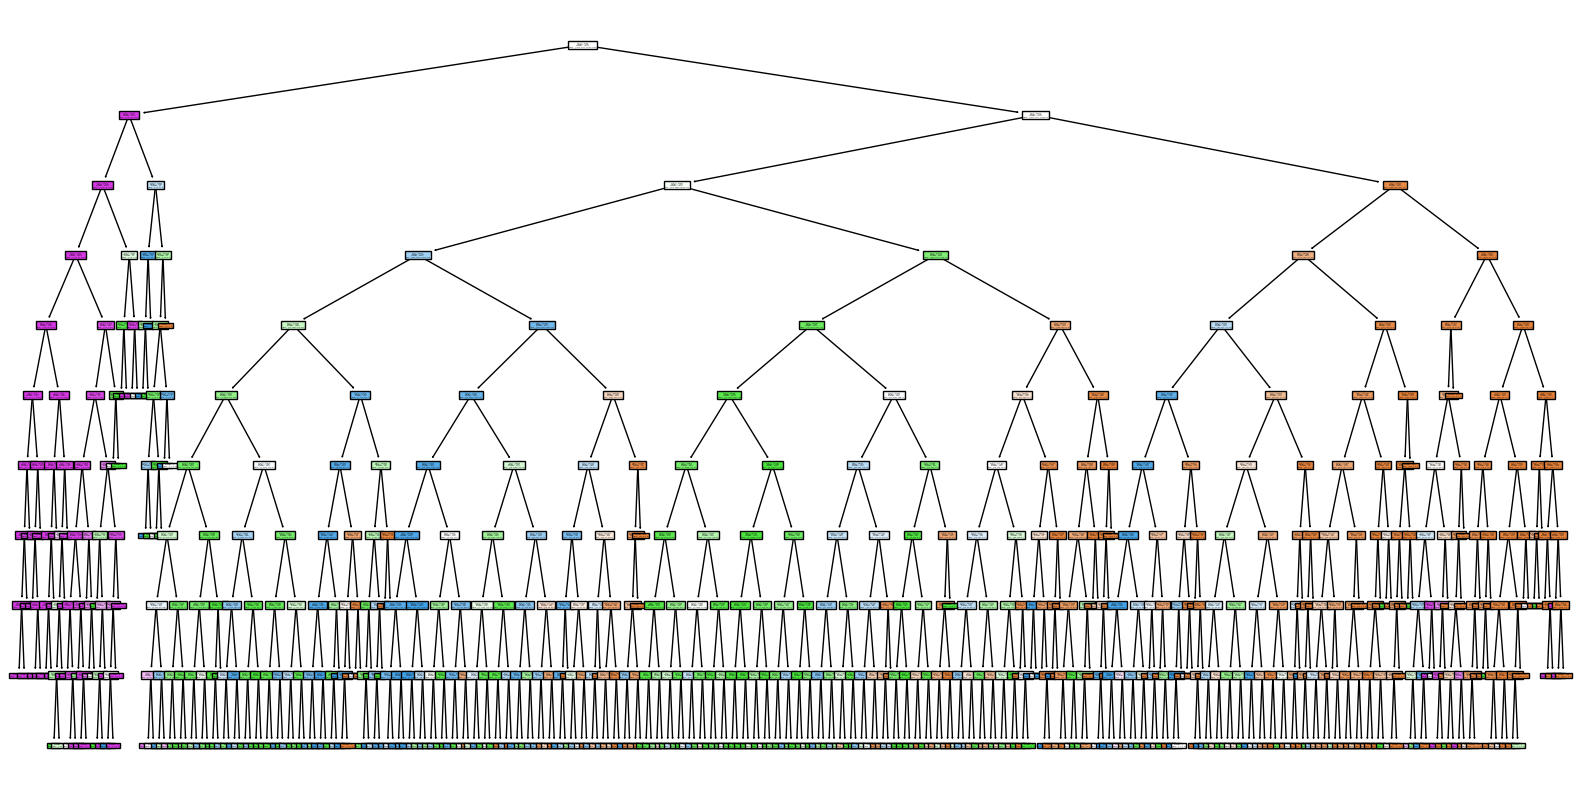

In [ ]:
#BEST MODEL - IMPOSTAZIONI QUI SOTTO - FILE best_model_16tw_noscaler.pkl È IL MODELLO A 8 MAX DEPTH IMPLEMENTATO SU ESP32
best_model = DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_leaf=2,
                       min_samples_split=2) #abbassare max depth a 8 per renderlo convertibile - senno troppo lungo da copiare.
#best_model.fit(X_train_psd, y_train)
best_model.fit(X_train_fft, y_train)
#salva il modello
#joblib.dump(best_model, 'best_model_16tw_noscaler_nosubstract.pkl')
#print del decision tree
from sklearn.tree import plot_tree
plt.figure(figsize=(20, 10))
plot_tree(best_model, filled=True, feature_names=None)
plt.show()

Test Accuracy decision tree: 0.9101578586135896
              precision    recall  f1-score   support

           0       0.90      0.99      0.94      3692
           1       0.91      0.82      0.86      3610
           2       0.83      0.84      0.84      3635
           3       1.00      0.99      0.99      3633

    accuracy                           0.91     14570
   macro avg       0.91      0.91      0.91     14570
weighted avg       0.91      0.91      0.91     14570

Confusion Matrix:
[[3659   20   13    0]
 [  74 2949  587    0]
 [ 327  249 3059    0]
 [   0   29   10 3594]]


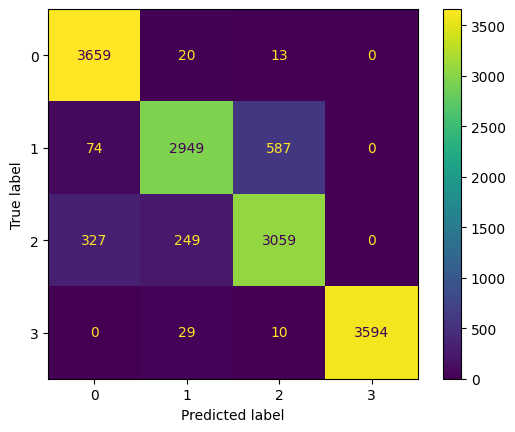

In [ ]:
#prediction on test set
X_test, y_test = create_windows(df_test, window_size)
y_test = to_categorical(y_test, num_classes=n_classes)
y_test = np.argmax(y_test, axis=1)

#X_test_psd = calculate_psd(X_test)
X_test_fft = calculate_fft(X_test)

#X_test_psd = scaler.transform(X_test_psd)
#X_test_fft = scaler.transform(X_test_fft)
#feature selection su test
#X_test_fft = clf_rf.transform(X_test_fft)
#y_test_pred_dt = best_model.predict(X_test_psd)
y_test_pred_dt = best_model.predict(X_test_fft)

test_accuracy_dt = accuracy_score(y_test, y_test_pred_dt)
print(f'Test Accuracy decision tree: {test_accuracy_dt}')
print(classification_report(y_test, y_test_pred_dt))
conf_matrix = confusion_matrix(y_test, y_test_pred_dt)
print('Confusion Matrix:')
print(conf_matrix)
# Puoi anche visualizzare la matrice di confusione con ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot()
plt.show()

In [ ]:
#print decision tree as text (Xfft now has no more feature names, only the index of the specific spectrum) poi tradurre l'output in codice c con chatgpt
from sklearn.tree import export_text
text_representation = export_text(best_model, feature_names=None)
print(text_representation)

|--- feature_17 <= 4.37
|   |--- feature_18 <= 12.11
|   |   |--- feature_0 <= 68.47
|   |   |   |--- feature_13 <= 3.46
|   |   |   |   |--- feature_0 <= 36.71
|   |   |   |   |   |--- feature_2 <= 6.68
|   |   |   |   |   |   |--- feature_0 <= 0.71
|   |   |   |   |   |   |   |--- feature_9 <= 2.63
|   |   |   |   |   |   |   |   |--- feature_18 <= 1.96
|   |   |   |   |   |   |   |   |   |--- class: 3
|   |   |   |   |   |   |   |   |--- feature_18 >  1.96
|   |   |   |   |   |   |   |   |   |--- class: 3
|   |   |   |   |   |   |   |--- feature_9 >  2.63
|   |   |   |   |   |   |   |   |--- class: 3
|   |   |   |   |   |   |--- feature_0 >  0.71
|   |   |   |   |   |   |   |--- class: 3
|   |   |   |   |   |--- feature_2 >  6.68
|   |   |   |   |   |   |--- feature_0 <= 12.71
|   |   |   |   |   |   |   |--- feature_1 <= 7.20
|   |   |   |   |   |   |   |   |--- class: 3
|   |   |   |   |   |   |   |--- feature_1 >  7.20
|   |   |   |   |   |   |   |   |--- feature_1 <= 9.66
|   | 

Accuracy: 0.9423605386095081
Classification Report:
              precision    recall  f1-score   support

           0       0.93      1.00      0.96      3685
           1       0.96      0.87      0.91      3610
           2       0.89      0.91      0.90      3635
           3       1.00      0.99      0.99      3626

    accuracy                           0.94     14556
   macro avg       0.94      0.94      0.94     14556
weighted avg       0.94      0.94      0.94     14556

Confusion Matrix:
[[3673    7    5    0]
 [  66 3143  401    0]
 [ 218  103 3314    0]
 [   0   29   10 3587]]


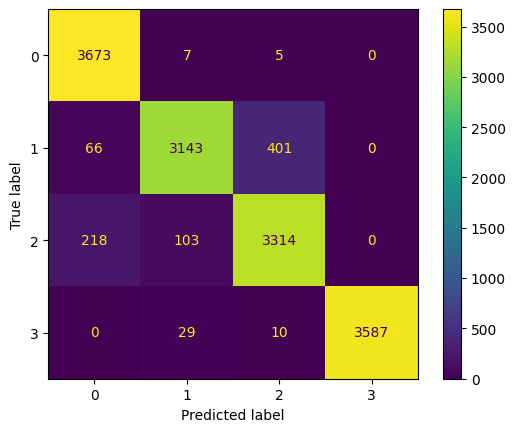

In [ ]:
def majority_voting(predictions, window_size=15): #30 window size -> almost 20 s   SU ARDUINO OGNI 2.6 S
    """
    Applica il majority voting su una sequenza di predizioni.

    Args:
        predictions: Un array NumPy di predizioni.
        window_size: La dimensione della finestra per il voting.

    Returns:
        Un array NumPy di predizioni dopo il majority voting.
    """

    voted_predictions = []
    for i in range(len(predictions) - window_size + 1):
        window = predictions[i : i + window_size]
        # Trova l'etichetta più frequente nella finestra
        most_frequent_label = np.bincount(window).argmax()
        voted_predictions.append(most_frequent_label)

    return np.array(voted_predictions)

# Applica il majority voting alle classi vere
voted_true_classes = majority_voting(y_test)
voted_predictions = majority_voting(y_test_pred_dt)
# Assicurati che le predizioni votate e le classi vere votate abbiano la stessa lunghezza
min_length = min(len(voted_predictions), len(voted_true_classes))
voted_predictions = voted_predictions[:min_length]
voted_true_classes = voted_true_classes[:min_length]

# Calcola l'accuracy
accuracy = accuracy_score(voted_true_classes, voted_predictions)
print(f'Accuracy: {accuracy}')

# Calcola il classification report
classification_rep = classification_report(voted_true_classes, voted_predictions)
print(f'Classification Report:\n{classification_rep}')

# Calcola la matrice di confusione
conf_matrix = confusion_matrix(voted_true_classes, voted_predictions)
print(f'Confusion Matrix:\n{conf_matrix}')

# Puoi anche visualizzare la matrice di confusione con ConfusionMatrixDisplay
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
disp.plot()
plt.show()

In [ ]:
# Visualizzazione della PSD per una finestra di tempo campione - 24 BINS (3X8)
import matplotlib.pyplot as plt

def plot_sample_psd(X_psd, sample_index=0):
    psd_sample = X_psd[sample_index]
    plt.figure(figsize=(10, 6))
    plt.plot(psd_sample)
    plt.title(f'PSD for Sample Index {sample_index}')
    plt.xlabel('Frequency Bins')
    plt.ylabel('Power Spectral Density')
    plt.show()

plot_sample_psd(X_train_fft, sample_index=30300)
